In [37]:
1+1

2

#  Transformer from Scratch — "Zero to Hero"


Implement the full Transformer architecture (Vaswani et al., 2017) from scratch using:

* 🖥️Local compute (CPU)

* PyTorch (no HuggingFace or other high-level libraries)

* Standard Python tools only (e.g., numpy, matplotlib, etc.)



#  Roadmap Overview


## Phase 1: Foundations

* 1.1 Tokenization 
* 1.2	Positional Encoding	
* 1.3	Scaled Dot-Product Attention	
* 1.4	Multi-Head Attention	- Parallel attentions + concatenation
* 1.5	Feed Forward Networks	- Fully connected sublayer
* 1.6	Layer Normalization + Residual	- Stability & skip connections
* 1.7	Encoder & Decoder Blocks	- Stack of modular blocks
* 1.8	Final Transformer Model -	Put it all together

---


##  Phase 2: Training Setup

* 2.1	Loss Function -	Label smoothing, cross-entropy
* 2.2	Masking - 	Padding & subsequent masking
* 2.3	Optimizer (Adam)	
* 2.4	Mini-batch DataLoader for	Efficient training

---

## Phase 3: Experimentation

* 3.1	Train on Toy Dataset	English → Pig Latin or reverse
* 3.2	Plot Attention Maps	Visualize self-attention
* 3.3	Inference	Beam search or greedy decoding
* 3.4	BLEU Score Eval	Validate model performance




Alright, LFG!

# 🔤 Step 1.1.A — Ultra-Simple Tokenizer (Andrej Kalapthy-style)

## 🧠 Goal
Create the simplest possible tokenizer that:
- Splits input text by whitespace
- Assigns each unique word a unique integer ID
- Pads sequences to a fixed length if needed

This will be enough for training on small toy datasets like:
- "I am a student" → [0, 1, 2, 3]

for the purpose of this proj, lets use this one

In [14]:
class Tokenizer:
    def __init__(self):
        self.vocab = {}
        self.reverse_vocab = {}

    def build_vocab(self, texts):
        """Assigns an index to every unique word in the dataset."""
        words = set()
        for text in texts:
            words.update(text.lower().split())

        self.vocab = {word: idx for idx, word in enumerate(sorted(words))}
        self.reverse_vocab = {idx: word for word, idx in self.vocab.items()}

    def encode(self, text):
        """Converts text to list of token ids."""
        return [self.vocab[word] for word in text.lower().split()]

    def decode(self, ids):
        """Converts token ids back to text."""
        return ' '.join([self.reverse_vocab[idx] for idx in ids])

In [18]:
# example usage

texts = [
    "I am a student",
    "You are a teacher"
]

tokenizer = Tokenizer()
tokenizer.build_vocab(texts)

for text in texts:
    ids = tokenizer.encode(text)
    print(f"Text   : {text}")
    print(f"Tokens : {ids}")
    print(f"Back   : {tokenizer.decode(ids)}\n")

Text   : I am a student
Tokens : [3, 1, 0, 4]
Back   : i am a student

Text   : You are a teacher
Tokens : [6, 2, 0, 5]
Back   : you are a teacher



# Step 1.1.B - Tokenization (Basic Word-level - BPE like as per Original Paper)

## Goal
Turn raw input text into token IDs that can be fed to the Transformer. The 2017 paper tokenized using subwords (like BPE), but for this, we’ll begin with a basic tokenizer that:
- Splits text on whitespace
- Maps each word to an integer ID
- Pads sequences to uniform length



In [12]:
from collections import Counter
import re

class SimpleTokenizer:
    def __init__(self, min_freq=1):
        self.min_freq = min_freq
        self.word2idx = {'<pad>': 0, '<unk>': 1}
        self.idx2word = {0: '<pad>', 1: '<unk>'}

    def build_vocab(self, sentences):
        word_freq = Counter()
        for sentence in sentences:
            tokens = self._tokenize(sentence)
            word_freq.update(tokens)
        
        for word, freq in word_freq.items():
            if freq >= self.min_freq:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word

    def _tokenize(self, sentence):
        # Basic whitespace and punctuation split
        sentence = sentence.lower()
        sentence = re.sub(r"[^a-zA-Z0-9]+", " ", sentence)
        return sentence.strip().split()

    def encode(self, sentence, max_len=None):
        tokens = self._tokenize(sentence)
        ids = [self.word2idx.get(tok, self.word2idx['<unk>']) for tok in tokens]
        if max_len:
            ids = ids[:max_len] + [self.word2idx['<pad>']] * max(0, max_len - len(ids))
        return ids

    def decode(self, ids):
        return ' '.join([self.idx2word.get(i, '<unk>') for i in ids])

In [16]:
# Example Usage

sentences = [
    "Hello world!",
    "Transformer models are amazing.",
    "Hello machine learning."
]

tokenizer = SimpleTokenizer(min_freq=1)
tokenizer.build_vocab(sentences)

for s in sentences:
    print(f"Original: {s}")
    print(f"Encoded : {tokenizer.encode(s, max_len=6)}")
    print()

Original: Hello world!
Encoded : [2, 3, 0, 0, 0, 0]

Original: Transformer models are amazing.
Encoded : [4, 5, 6, 7, 0, 0]

Original: Hello machine learning.
Encoded : [2, 8, 9, 0, 0, 0]



---

# 📍 Step 1.2 — Positional Encoding

## 📘 Why Do We Need It?

Transformers operate on entire sequences in parallel — there's no concept of “position” unless we explicitly encode it.

**Positional Encoding** injects information about token order using a **deterministic, fixed-size vector** that gets **added to the input embeddings**.

---

## 🧠 Mathematical Formulation (from the paper)

For a given position $pos$ and dimension $i$ in the embedding:

$$
\text{PE}_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

$$
\text{PE}_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

Where:
- $pos$: Position in the sequence
- $i$: Dimension index
- $d_{\text{model}}$: Embedding dimension

### 🔍 Intuition:
- Different frequencies of sine/cosine encode position.
- Even/odd dimensions alternate sin/cos curves.
- Nearby positions produce similar vectors — enabling relative position detection.


### 📚 Resources
* 📖 Original Paper, Section 3.5
* 🧠 Jay Alammar - The Illustrated Transformer (Positional Encoding)
* 🧮 3Blue1Brown - Fourier Series Intuition (Great intuition behind sinusoids & frequency basis)


In [19]:
import torch
import math

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        """
        d_model: embedding dimension
        max_len: maximum length of input sequence
        """
        super().__init__()

        # Step 1: Create a matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)

        # Step 2: Create a vector of positions [0, 1, 2, ..., max_len-1]
        position = torch.arange(0, max_len).unsqueeze(1)  # Shape: (max_len, 1)

        # Step 3: Compute the denominator term of the PE formula
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        # Shape: (d_model/2,)

        # Step 4: Apply sin to even indices
        pe[:, 0::2] = torch.sin(position * div_term)

        # Step 5: Apply cos to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)

        # Step 6: Add batch dimension (1, max_len, d_model)
        pe = pe.unsqueeze(0)

        # Step 7: Register as a buffer (not a parameter)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: (batch_size, seq_len, d_model)
        returns: input + positional encoding (trimmed to seq_len)
        """
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len]
        return x

In [29]:
# ✅ Example: Add Positional Encoding to Toy Inputs


# Example embedding input: (batch=1, seq_len=4, d_model=32)
dummy_input = torch.zeros(1, 4, 32)

# Create the PositionalEncoding module
pe = PositionalEncoding(d_model=32, max_len=10)

# Add positional info to the dummy input
output = pe(dummy_input)

print(output[0])  # Print the PE vectors for each position


tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  5.3317e-01,  8.4601e-01,  3.1098e-01,
          9.5042e-01,  1.7689e-01,  9.8423e-01,  9.9833e-02,  9.9500e-01,
          5.6204e-02,  9.9842e-01,  3.1618e-02,  9.9950e-01,  1.7782e-02,
          9.9984e-01,  9.9998e-03,  9.9995e-01,  5.6234e-03,  9.9998e-01,
          3.1623e-03,  9.9999e-01,  1.7783e-03,  1.0000e+00,  1.0000e-03,
          1.0000e+00,  5.6234e-04,  1.0000e+00,  3.1623e-04,  1.0000e+00,
          1.7783e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.02

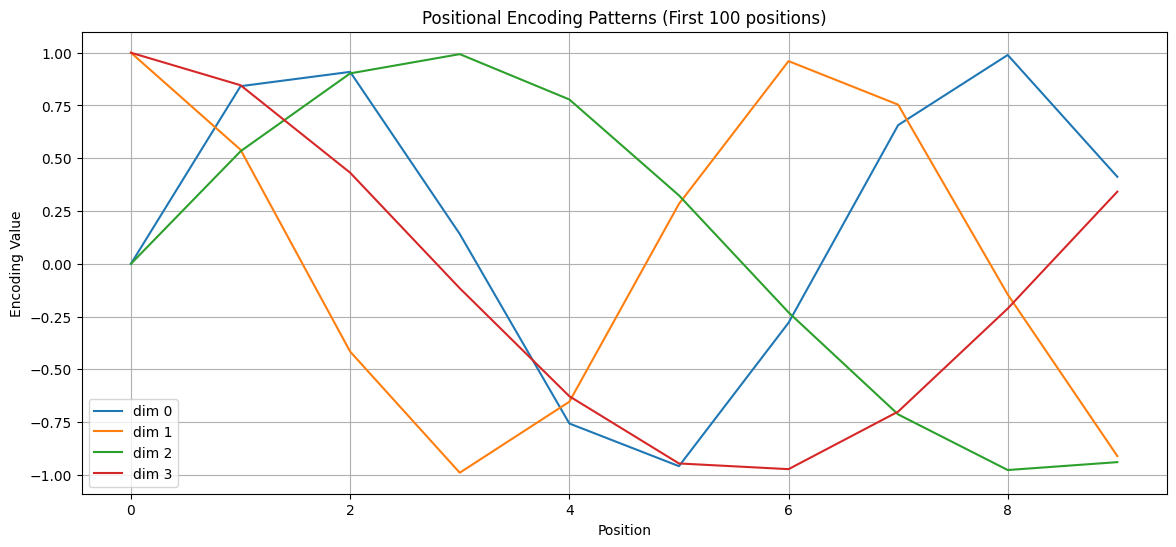

In [30]:
# 📊 Visualization

import matplotlib.pyplot as plt

pe_matrix = pe.pe[0, :100].detach().numpy()  # (100, d_model)

plt.figure(figsize=(14, 6))
plt.plot(pe_matrix[:, 0], label="dim 0")
plt.plot(pe_matrix[:, 1], label="dim 1")
plt.plot(pe_matrix[:, 2], label="dim 2")
plt.plot(pe_matrix[:, 3], label="dim 3")
plt.legend()
plt.title("Positional Encoding Patterns (First 100 positions)")
plt.xlabel("Position")
plt.ylabel("Encoding Value")
plt.grid(True)
plt.show()


---

# 🎯 Step 1.3 — Scaled Dot-Product Attention

---

## 🧠 Motivation

Given a query vector and a set of key-value pairs:
- The query is compared to all keys → to produce weights.
- These weights are used to compute a **weighted sum of values**.

This allows the model to "attend" to relevant parts of the input dynamically.

---

## 📘 Formula

Given:
- Query matrix $Q \in \mathbb{R}^{L_q \times d_k}$
- Key matrix $K \in \mathbb{R}^{L_k \times d_k}$
- Value matrix $V \in \mathbb{R}^{L_k \times d_v}$

The output is computed as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right) V
$$

### 🔍 Explanation:
- $QK^T$: Measures similarity between queries and keys
- $1/\sqrt{d_k}$: Scales to avoid large dot products → more stable gradients
- softmax: Converts similarities into a probability distribution
- Multiply with $V$: Produces weighted sum of value vectors


In [31]:
import torch
import torch.nn.functional as F

def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Q: (batch_size, seq_len_q, d_k)
    K: (batch_size, seq_len_k, d_k)
    V: (batch_size, seq_len_k, d_v)
    mask: (batch_size, seq_len_q, seq_len_k), optional
    """
    d_k = Q.size(-1)  # key dimension

    # Step 1: Compute raw scores (dot product)
    scores = torch.matmul(Q, K.transpose(-2, -1))  # (batch, seq_q, seq_k)

    # Step 2: Scale the scores
    scores = scores / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    # Step 3: Apply mask (optional) - to be used in decoder
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

    # Step 4: Normalize scores with softmax
    attn_weights = F.softmax(scores, dim=-1)

    # Step 5: Multiply by values
    output = torch.matmul(attn_weights, V)  # (batch, seq_q, d_v)

    return output, attn_weights

In [32]:
# Toy example


# Toy Q, K, V (batch_size=1, seq_len=3, dim=4)
Q = torch.tensor([[[1.0, 0.0, 1.0, 0.0]]])  # shape (1, 1, 4)
K = torch.tensor([[[1.0, 0.0, 1.0, 0.0],
                   [0.0, 1.0, 0.0, 1.0],
                   [1.0, 1.0, 0.0, 0.0]]])  # shape (1, 3, 4)
V = torch.tensor([[[10.0, 0.0],
                   [0.0, 10.0],
                   [5.0, 5.0]]])  # shape (1, 3, 2)

output, attn_weights = scaled_dot_product_attention(Q, K, V)

print("Attention Weights:\n", attn_weights)
print("Output:\n", output)

Attention Weights:
 tensor([[[0.5065, 0.1863, 0.3072]]])
Output:
 tensor([[[6.6008, 3.3992]]])


---

# 🧠 Step 1.4 — Multi-Head Attention (MHA)

---

## 📘 Motivation

Instead of performing a single attention function with full-dimensional vectors, we **project into multiple smaller subspaces** and perform attention **in parallel**.

This allows the model to:
- Learn different types of relationships
- Attend to different positions simultaneously

---

## 🧪 What is Multi-Head Attention?

Given input matrices $Q$, $K$, and $V$, we perform $h$ parallel attention computations using **different learned projections**:

### 🔢 Equations

For each head $i \in [1, h]$:

$$
\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
$$

Then concatenate all heads:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O
$$

- $W_i^Q$, $W_i^K$, $W_i^V$: Projection matrices for head $i$
- $W^O$: Final projection after concatenating heads


In [81]:
import torch
import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        """
        d_model: total embedding dimension
        num_heads: number of attention heads
        """
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # dimension per head

        # Linear layers for projecting Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Final linear layer after concatenation
        self.W_o = nn.Linear(d_model, d_model)

        # for visualization(step 3.2
        self.last_attn_weights = None

    # same as section 1.32
    def scaled_dot_product_attention(Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn_weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, V)
        return output, attn_weights

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)

        # Step 1: Linear projections
        Q = self.W_q(Q)  # (batch, seq_len, d_model)
        K = self.W_k(K)
        V = self.W_v(V)

        # Step 2: Reshape for multi-head: (batch, num_heads, seq_len, d_k)
        def reshape(x):
            return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        Q = reshape(Q)
        K = reshape(K)
        V = reshape(V)

        # Step 3: Scaled dot-product attention (per head)
        output, attn_weights = scaled_dot_product_attention(Q, K, V, mask)  # (batch, heads, seq_len, d_k)
        
        # LATER STEP (3.2) add this line to visualize attention weights
        self.last_attn_weights = attn_weights.detach()  # shape: (batch, heads, tgt_len, src_len)

        # Step 4: Concatenate heads and apply final linear projection
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        
        return self.W_o(output), attn_weights

In [36]:
# Toy input: (batch=2, seq_len=4, d_model=8)
x = torch.rand(2, 4, 8)

mha = MultiHeadAttention(d_model=8, num_heads=2)
out, weights = mha(x, x, x)

print("Output shape:", out.shape)  # (2, 4, 8)
print("Attention weights shape:", weights.shape)  # (2, 2, 4, 4)

Output shape: torch.Size([2, 4, 8])
Attention weights shape: torch.Size([2, 2, 4, 4])


---

# ⚙️ Step 1.5 — Position-wise Feed Forward Network (FFN)

---

## 🧠 Motivation

After each attention block, the Transformer applies a **fully connected feed-forward network** to every position **independently and identically**.

This introduces **non-linearity** and **increased capacity** to model complex patterns.

---

## 📘 Formula (From the Paper)

Given input $x \in \mathbb{R}^{d_{\text{model}}}$:

$$
\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
$$

- $W_1 \in \mathbb{R}^{d_{\text{model}} \times d_{\text{ff}}}$: Expands dimensionality
- $W_2 \in \mathbb{R}^{d_{\text{ff}} \times d_{\text{model}}}$: Projects back
- Common values: $d_{\text{ff}} = 2048$, $d_{\text{model}} = 512$

> ⚠️ This FFN is applied to each token (position) **independently**, not across time/sequence(hence parallelism).

---

## 🧠 Why Use FFN?
* Attention focuses on relationships across positions.
* FFN increases representation power at each position.
* They work together: attention handles dependencies, FFN handles transformation.


In [38]:
import torch
import torch.nn as nn

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        """
        d_model: Input and output dimension
        d_ff: Hidden dimension (usually larger)
        """
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)   # First layer expands
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)   # Second layer projects back

    def forward(self, x):
        # Step 1: Expand -> Step 2: ReLU -> Step 3: Dropout -> Step 4: Project
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [39]:
## usage example

ffn = FeedForward(d_model=8, d_ff=32)
x = torch.rand(2, 4, 8)  # (batch=2, seq_len=4, d_model=8)

output = ffn(x)
print("Output shape:", output.shape)  # (2, 4, 8)

Output shape: torch.Size([2, 4, 8])


---

# 🔁 Step 1.6 — Residual Connections + Layer Normalization

---

## 🧠 Why Do We Need This?

Training deep networks can be unstable. Two key ideas help:
1. **Residual connections**: Help gradients flow (prevent vanishing)
2. **Layer normalization**: Stabilizes activations by normalizing across features

These techniques make **very deep attention models trainable and robust**.

---

## 🔃 Residual + LayerNorm: Formula

Given a sub-layer (e.g., attention or FFN) and its input $x$:

$$
\text{LayerNorm}(x + \text{Sublayer}(x))
$$

- Residual connection: $x + \text{Sublayer}(x)$
- LayerNorm: normalizes across features at each position (unlike BatchNorm)


In [43]:
# Sublayer Wrapper Module

import torch
import torch.nn as nn

class ResidualLayerNorm(nn.Module):
    def __init__(self, size, dropout=0.1):
        """
        size: dimensionality of input/output (typically d_model)
        """
        super().__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer_fn):
        """
        sublayer_fn: function that applies attention or FFN to x
        """
        return self.norm(x + self.dropout(sublayer_fn(x)))

In [45]:
# Example Usage with Attention + FFN


d_model = 8
x = torch.rand(2, 4, d_model)  # (batch, seq_len, d_model)

# Dummy modules
self_attn = nn.Linear(d_model, d_model)
ffn = nn.Sequential(nn.Linear(d_model, 32), nn.ReLU(), nn.Linear(32, d_model))

# Residual wrappers
resnorm1 = ResidualLayerNorm(d_model)
resnorm2 = ResidualLayerNorm(d_model)

# Wrap attention
x = resnorm1(x, lambda x: self_attn(x))

# Wrap feed forward
x = resnorm2(x, lambda x: ffn(x))
x

tensor([[[ 1.2312,  1.3623, -0.6684, -1.2674,  0.7179, -0.4324, -1.3166,
           0.3733],
         [ 0.0981,  1.4754, -1.6599,  0.9026,  0.0235, -0.2269,  0.6946,
          -1.3074],
         [ 0.3428,  1.9266, -1.5463, -0.1704,  0.6745, -0.8563,  0.3113,
          -0.6823],
         [ 0.8855,  1.6226, -1.0696, -0.5395,  0.9339, -0.6995, -1.3230,
           0.1897]],

        [[ 0.4075,  2.0810, -0.9986, -0.6926,  0.4225, -0.9130,  0.5420,
          -0.8488],
         [ 0.8068,  0.7781, -1.9725,  0.2876, -0.5757,  0.9968, -0.9952,
           0.6741],
         [-0.6999,  2.0103, -1.0488,  0.2054, -0.5341, -1.0877,  0.8871,
           0.2676],
         [ 0.0301,  0.5195, -0.6992,  0.5291,  1.9768,  0.0284, -0.8699,
          -1.5149]]], grad_fn=<NativeLayerNormBackward0>)

---

# 🧱 Step 1.7 — Transformer Encoder & Decoder Blocks

---

## 🎯 Objective

We’ll now build:

1. **Encoder Block** = 
   - Multi-head self-attention
   - Residual + LayerNorm
   - Feed-forward network
   - Residual + LayerNorm

2. **Decoder Block** = 
   - Masked multi-head self-attention
   - Encoder-Decoder attention
   - Feed-forward network
   - Residuals + LayerNorm after each

---

## 🧠 Encoder Block Diagram

```css
    Input Embeddings
          ↓
┌────────────────────┐
│  MultiHead SelfAttn│
└────────────────────┘
         ↓ + norm
┌────────────────────┐
│   FeedForwardNet   │
└────────────────────┘
         ↓ + norm
    Output to next

```

---

## Decoder block diagram

```css
        Target Embeddings
              ↓
    ┌────────────────────────┐
    │ Masked MultiHead Attn  │
    └────────────────────────┘
             ↓ + norm
    ┌────────────────────────┐
    │ Encoder-Decoder Attn   │
    └────────────────────────┘
             ↓ + norm
    ┌────────────────────────┐
    │   FeedForwardNet       │
    └────────────────────────┘
             ↓ + norm
        Output to next
```


In [49]:
# Encoder Block
import torch.nn as nn

class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.resnorm1 = ResidualLayerNorm(d_model, dropout)
        self.resnorm2 = ResidualLayerNorm(d_model, dropout)

    def forward(self, x, mask=None):
        # Apply self-attention with residual connection
        x = self.resnorm1(x, lambda x: self.attn(x, x, x, mask)[0])
        # Apply feed-forward network with residual
        x = self.resnorm2(x, self.ffn)
        return x

In [48]:
# Decoder block

class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.resnorm1 = ResidualLayerNorm(d_model, dropout)
        self.resnorm2 = ResidualLayerNorm(d_model, dropout)
        self.resnorm3 = ResidualLayerNorm(d_model, dropout)

    def forward(self, x, enc_output, tgt_mask=None, src_mask=None):
        # Step 1: Masked self-attention
        x = self.resnorm1(x, lambda x: self.self_attn(x, x, x, tgt_mask)[0])
        # Step 2: Encoder-Decoder attention
        x = self.resnorm2(x, lambda x: self.enc_dec_attn(x, enc_output, enc_output, src_mask)[0])
        # Step 3: Feed forward
        x = self.resnorm3(x, self.ffn)
        return x

---

# 🏗️ Step 1.8 — Full Transformer Model

---

## 🎯 Objective

Assemble the full Transformer architecture:

- Token + Positional embeddings
- Stacked Encoder and Decoder blocks
- Final linear + softmax output for prediction

---

## 🧠 Overall Architecture Diagram

```css
    ┌───────────────────────────────┐
    │        Input Tokens           │
    └───────────────────────────────┘
                 ↓
    ┌───────────────────────────────┐
    │  Token + Positional Embedding │
    └───────────────────────────────┘
                 ↓
    ┌───────────────────────────────┐
    │         Encoder Stack         │
    └───────────────────────────────┘
                 ↓
    ┌───────────────────────────────┐
    │    Decoder Input + PosEmbed   │
    └───────────────────────────────┘
                 ↓
    ┌───────────────────────────────┐
    │         Decoder Stack         │
    └───────────────────────────────┘
                 ↓
    ┌───────────────────────────────┐
    │ Linear → Softmax (vocab size) │
    └───────────────────────────────┘
```

In [52]:
# 🧱 Code: Full Transformer Module

import torch
import torch.nn as nn

class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_len=512, dropout=0.1):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)

        # Encoder stack
        self.encoder_layers = nn.ModuleList([
            EncoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        # Decoder stack
        self.decoder_layers = nn.ModuleList([
            DecoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        # Final projection to vocab
        self.final_linear = nn.Linear(d_model, vocab_size)

    def encode(self, src, src_mask=None):
        x = self.token_embedding(src)
        x = self.pos_encoding(x)
        for layer in self.encoder_layers:
            x = layer(x, src_mask)
        return x

    def decode(self, tgt, enc_output, tgt_mask=None, src_mask=None):
        x = self.token_embedding(tgt)
        x = self.pos_encoding(x)
        for layer in self.decoder_layers:
            x = layer(x, enc_output, tgt_mask, src_mask)
        return x

    """
    When you call a PyTorch model like this:
        
        out = model(src, tgt)

    What’s really happening behind the scenes is:

        out = model.__call__(src, tgt)  # PyTorch internals
        ↓
        calls model.forward(src, tgt)
        ↓
        calls encode() & decode()
    """
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        enc_output = self.encode(src, src_mask)
        dec_output = self.decode(tgt, enc_output, tgt_mask, src_mask)
        return self.final_linear(dec_output)  # logits over vocab

In [53]:
# Example Instantiation
model = Transformer(
    vocab_size=1000,
    d_model=512,
    num_heads=8,
    d_ff=2048,
    num_layers=6,
    max_len=100,
    dropout=0.1
)

src = torch.randint(0, 1000, (2, 10))  # (batch=2, src_len=10)
tgt = torch.randint(0, 1000, (2, 10))  # (batch=2, tgt_len=10)

out = model(src, tgt)  # output shape: (2, 10, 1000)
print(out.shape)

torch.Size([2, 10, 1000])


# Phase 2: Training Setup

# 🧪 Step 2.1 & 2.2 — Loss Function + Masking

---

## 🧠 Goal

Prepare the Transformer for training by defining:

- A proper **loss function** (with optional label smoothing)
- **Masking** strategies for:
  - Padding tokens (in both encoder and decoder)
  - Preventing decoder from "seeing the future" (causal mask)

---

## 🧩 Why Masking?

1. **Padding Mask**: Prevents model from attending to `<pad>` tokens.
2. **Causal Mask** (Look-ahead): Prevents decoder from cheating during training.

---

## 🎯 Target Loss: Cross Entropy

The model’s output shape:

- `logits`: (batch_size, seq_len, vocab_size)
- `targets`: (batch_size, seq_len)

We use PyTorch’s `nn.CrossEntropyLoss` — optionally with ignored tokens.


In [56]:
## 🧪 Code: Create Padding Mask
def create_padding_mask(seq, pad_token=0):
    """
    Returns a mask tensor with shape (batch_size, 1, 1, seq_len)
    Suitable for broadcasting into attention scores
    """
    # (batch, seq_len) → (batch, 1, 1, seq_len)
    return (seq != pad_token).unsqueeze(1).unsqueeze(2)

# 🧪 Code: Create Causal (Look-Ahead) Mask
def create_causal_mask(size):
    """
    Returns a lower triangular matrix (1s below diagonal)
    Shape: (1, 1, seq_len, seq_len)
    """
    mask = torch.tril(torch.ones(size, size)).bool()
    return mask.unsqueeze(0).unsqueeze(0)  # shape (1, 1, size, size)

# 🔥 Combine Masks for Decoder
def combine_masks(padding_mask, causal_mask):
    return padding_mask & causal_mask  # shape: (batch, 1, tgt_len, tgt_len)

In [57]:
# 🧪 Code: Cross Entropy Loss
import torch.nn as nn

def get_loss_function(pad_token=0):
    """
    Returns a loss function that ignores padding tokens
    """
    return nn.CrossEntropyLoss(ignore_index=pad_token)

In [ ]:
# 🧪 Sample Training Step (Sketch) - how to run

logits = model(src, tgt_input, src_mask, tgt_mask)  # (batch, seq_len, vocab)
loss_fn = get_loss_function()

# Reshape for loss: (batch * seq_len, vocab)
logits = logits.view(-1, logits.size(-1))
tgt_labels = tgt_output.view(-1)

loss = loss_fn(logits, tgt_labels)

---

# 🚀 Step 2.3 — Optimizer + Learning Rate Scheduler

---

## 🧠 Why Custom Scheduling?

In the Transformer paper, the authors proposed a **warmup-based learning rate schedule** to stabilize training:

- Start with a **low learning rate**, increase it **linearly** for a few thousand steps
- Then **decay it proportionally** to the inverse square root of the step number

---

## 🔢 Formula (from the paper)

For step number $t$ and model dimension $d_{\text{model}}$:

$$
\text{LR}(t) = d_{\text{model}}^{-0.5} \cdot \min(t^{-0.5},\ t \cdot \text{warmup\_steps}^{-1.5})
$$

- Helps avoid large updates at the start
- Supports stable long training runs

In [59]:
## 🧪 Code: Custom Optimizer Wrapper

import torch.optim as optim

class TransformerLRScheduler:
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.step_num = 0
        self.warmup_steps = warmup_steps
        self.d_model = d_model

    def step(self):
        self.step_num += 1
        lr = self._compute_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        self.optimizer.step()

    def _compute_lr(self):
        arg1 = self.step_num ** -0.5
        arg2 = self.step_num * (self.warmup_steps ** -1.5)
        return (self.d_model ** -0.5) * min(arg1, arg2)

    def zero_grad(self):
        self.optimizer.zero_grad()

In [60]:
# 🔧 Instantiating the Optimizer

model = Transformer(
    vocab_size=1000,
    d_model=512,
    num_heads=8,
    d_ff=2048,
    num_layers=6,
    max_len=100
)

base_optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)
scheduler = TransformerLRScheduler(base_optimizer, d_model=512)

In [ ]:
# 🧪 In Training Loop - how to use

for epoch in range(num_epochs):
    for batch in dataloader:
        src, tgt_input, tgt_output = batch

        output = model(src, tgt_input)
        logits = output.view(-1, output.size(-1))
        tgt = tgt_output.view(-1)

        loss = loss_fn(logits, tgt)
        scheduler.zero_grad()
        loss.backward()
        scheduler.step()

# 📦 Step 2.4 — Dataset + DataLoader for Toy Tasks

---

## 🧠 Goal

Build a simple dataset for sequence-to-sequence tasks like:

- Reverse strings: `"i am fine"` → `"fine am i"`
- Copy strings: `"hello world"` → `"hello world"`

This helps verify that your model architecture and training loop are working.


In [61]:
## 🧪 Step 1: Build a Tiny Vocabulary

PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2

SPECIAL_TOKENS = ["<pad>", "<sos>", "<eos>"]

class Vocab:
    def __init__(self):
        self.token2id = {tok: i for i, tok in enumerate(SPECIAL_TOKENS)}
        self.id2token = {i: tok for tok, i in self.token2id.items()}
        self.next_id = len(self.token2id)

    def add_sentence(self, sentence):
        for word in sentence.split():
            if word not in self.token2id:
                self.token2id[word] = self.next_id
                self.id2token[self.next_id] = word
                self.next_id += 1

    def encode(self, sentence, add_sos_eos=True):
        tokens = [self.token2id.get(w, PAD_TOKEN) for w in sentence.split()]
        if add_sos_eos:
            return [SOS_TOKEN] + tokens + [EOS_TOKEN]
        return tokens

    def decode(self, ids):
        return " ".join([self.id2token.get(i, "<unk>") for i in ids])

    def __len__(self):
        return self.next_id

In [62]:
# 🧪 Step 2: Generate Reversal Task Dataset

import random

def generate_reversal_data(n=1000):
    words = ["i", "am", "fine", "you", "are", "great", "hello", "world", "how", "is", "life"]
    data = []
    for _ in range(n):
        seq_len = random.randint(3, 6)
        sentence = " ".join(random.choices(words, k=seq_len))
        reversed_sentence = " ".join(sentence.split()[::-1])
        data.append((sentence, reversed_sentence))
    return data

In [63]:
# 🧪 Step 3: Dataset + Collate Function

import torch
from torch.utils.data import Dataset, DataLoader

class Seq2SeqDataset(Dataset):
    def __init__(self, pairs, vocab):
        self.pairs = pairs
        self.vocab = vocab

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        src_ids = self.vocab.encode(src)
        tgt_ids = self.vocab.encode(tgt)
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

def pad_batch(batch):
    src_batch, tgt_batch = zip(*batch)
    src_lens = [len(s) for s in src_batch]
    tgt_lens = [len(t) for t in tgt_batch]

    max_src = max(src_lens)
    max_tgt = max(tgt_lens)

    padded_src = [F.pad(s, (0, max_src - len(s)), value=PAD_TOKEN) for s in src_batch]
    padded_tgt = [F.pad(t, (0, max_tgt - len(t)), value=PAD_TOKEN) for t in tgt_batch]

    src_batch = torch.stack(padded_src)
    tgt_batch = torch.stack(padded_tgt)
    return src_batch, tgt_batch

In [64]:
# 🧪 Step 4: Final DataLoader

pairs = generate_reversal_data(1000)
vocab = Vocab()
for src, tgt in pairs:
    vocab.add_sentence(src)
    vocab.add_sentence(tgt)

dataset = Seq2SeqDataset(pairs, vocab)
loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=pad_batch)

# Check a batch
src_batch, tgt_batch = next(iter(loader))
print("SRC:", src_batch.shape)
print("TGT:", tgt_batch.shape)

SRC: torch.Size([32, 8])
TGT: torch.Size([32, 8])


---

# Phase 3: Training & Evaluation!

# 🏋️ Step 3.1 — Training on a Toy Task (Sequence Reversal)

---

## 🎯 Task

Given an input like:
```
i am fine → fine am i
```

Train your model to learn this mapping — the perfect starting point to debug and validate your architecture.


In [66]:
# 🧪 Training Loop

import torch
import torch.nn.functional as F

def train_epoch(model, dataloader, loss_fn, optimizer, scheduler, pad_token=0):
        model.train()  # Set model to training mode
    total_loss = 0  # Track total loss for averaging

    for src, tgt in dataloader:
        src = src.to(device)  # Move source to device (CPU or GPU)
        tgt = tgt.to(device)  # Move target to device

        # Split target into decoder input and target output for teacher forcing
        tgt_input = tgt[:, :-1]          # Decoder input (starts with <sos>)
        tgt_output = tgt[:, 1:]          # Target output (ends with <eos>)

        # Create masks
        src_mask = create_padding_mask(src, pad_token=pad_token).to(device)           # Mask <pad> in encoder input
        tgt_pad_mask = create_padding_mask(tgt_input, pad_token=pad_token).to(device) # Mask <pad> in decoder input
        tgt_causal_mask = create_causal_mask(tgt_input.size(1)).to(device)            # Prevent decoder from attending to future tokens
        tgt_mask = tgt_pad_mask & tgt_causal_mask                                     # Combine both masks

        # Forward pass through the model
        logits = model(src, tgt_input, src_mask, tgt_mask)  # Output: (batch, tgt_seq_len, vocab_size)

        # Flatten logits and targets to match CrossEntropyLoss expectations
        logits = logits.view(-1, logits.size(-1))           # Shape: (batch * seq_len, vocab)
        tgt_output = tgt_output.reshape(-1)                 # Shape: (batch * seq_len,)

        # Compute loss
        loss = loss_fn(logits, tgt_output)

        # Backpropagation + optimization
        scheduler.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagate
        scheduler.step()       # Update weights + learning rate

        total_loss += loss.item()  # Accumulate scalar loss

    return total_loss / len(dataloader)  # Return average loss across all batches

## 🧪 Run Training

In [67]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model setup
vocab_size = len(vocab)
model = Transformer(
    vocab_size=vocab_size,
    d_model=128,
    num_heads=4,
    d_ff=512,
    num_layers=2,
    max_len=64,
    dropout=0.1
).to(device)

loss_fn = get_loss_function(pad_token=PAD_TOKEN)
base_optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)
scheduler = TransformerLRScheduler(base_optimizer, d_model=128)

# Run training
for epoch in range(1, 11):
    loss = train_epoch(model, loader, loss_fn, scheduler, scheduler)
    print(f"Epoch {epoch:2d} | Loss: {loss:.4f}")

Using device: cpu
Epoch  1 | Loss: 2.7028
Epoch  2 | Loss: 2.5607
Epoch  3 | Loss: 2.4146
Epoch  4 | Loss: 2.2798
Epoch  5 | Loss: 2.0711
Epoch  6 | Loss: 1.8088
Epoch  7 | Loss: 1.5430
Epoch  8 | Loss: 1.3017
Epoch  9 | Loss: 1.0215
Epoch 10 | Loss: 0.7245


# 👁️ Step 3.2 — Visualizing Attention Weights

---

## 🎯 Goal

- Visualize attention matrices from one or more attention heads.
- Helps understand if the model is:
  - Focusing on relevant source tokens
  - Learning positional dependencies (e.g., in reversal or translation)

---

## 📌 What Are We Visualizing?

From multi-head attention:
- Attention weights shape: **(batch, num_heads, tgt_seq_len, src_seq_len)**
- We’ll visualize this as a heatmap for a given sample and head.

---

## 🧪 Update: Capture Attention Weights During Forward Pass

### ✅ First, modify `MultiHeadAttention` to store weights:

In your `MultiHeadAttention.forward()` method, **add this line**:

```python
self.last_attn_weights = attn_weights.detach()  # shape: (batch, heads, tgt_len, src_len)
```
> 🔁 This makes the most recent attention weights available after each forward pass.



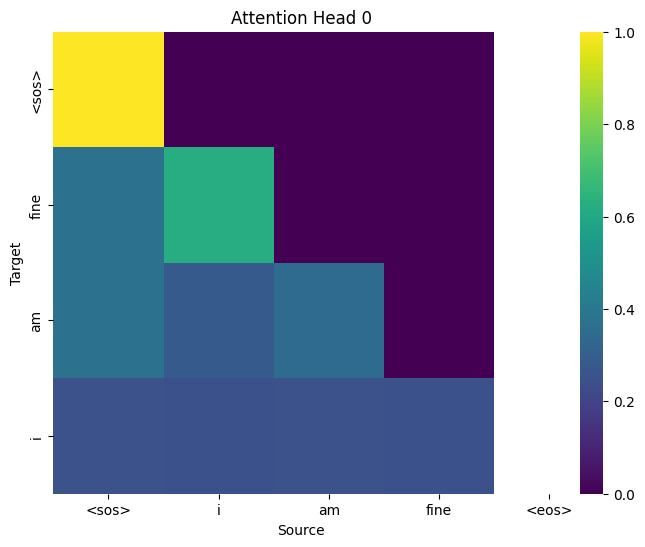

In [84]:
# 🧪 Visualization Function

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(model, src_sentence, tgt_sentence, src_vocab, tgt_vocab, head=0):
    """
    src_sentence: str (input sentence)
    tgt_sentence: str (used only for visualization)
    head: which attention head to visualize
    """

    model.eval()
    with torch.no_grad():
        # Encode tokens
        src_ids = torch.tensor([src_vocab.encode(src_sentence)]).to(device)
        tgt_ids = torch.tensor([tgt_vocab.encode(tgt_sentence)[:-1]]).to(device)  # remove <eos> to match decoder input

        # Create masks
        src_mask = create_padding_mask(src_ids).to(device)
        tgt_mask = combine_masks(
            create_padding_mask(tgt_ids).to(device),
            create_causal_mask(tgt_ids.size(1)).to(device)
        )

        # Forward pass
        output = model(src_ids, tgt_ids, src_mask, tgt_mask)

        # Extract attention weights from the last decoder layer, first head
        attn = model.decoder_layers[-1].self_attn.last_attn_weights
        attn = attn[0, head]  # (tgt_len, src_len)

        # Decode token ids
        src_tokens = src_vocab.decode(src_ids[0].tolist()).split()
        tgt_tokens = tgt_vocab.decode(tgt_ids[0].tolist()).split()

        # Plot heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(attn.cpu().numpy(), xticklabels=src_tokens, yticklabels=tgt_tokens, cmap="viridis")
        plt.xlabel("Source")
        plt.ylabel("Target")
        plt.title(f"Attention Head {head}")
        plt.show()

# example usage
visualize_attention(model, "i am fine", "fine am i", vocab, vocab, head=0)


# 🤖 Step 3.3 — Greedy Decoding (Inference)

---

## 🎯 Goal

Use the trained Transformer to generate output **one token at a time**, without knowing the full target sequence.

---

## 🧠 Strategy

- Input: source sentence (e.g. `"i am fine"`)
- Start decoding with: `<sos>`
- At each step:
  - Predict next token using model
  - Append predicted token to decoder input
- Stop when:
  - Model predicts `<eos>` OR
  - Maximum length is reached


In [89]:
def greedy_decode(model, src_sentence, src_vocab, tgt_vocab, max_len=30):
    model.eval()

    with torch.no_grad():
        # Encode source sentence
        src_ids = torch.tensor([src_vocab.encode(src_sentence)]).to(device)
        src_mask = create_padding_mask(src_ids).to(device)
        enc_output = model.encode(src_ids, src_mask)

        # Start decoder with <sos>
        decoded = [SOS_TOKEN]
        for _ in range(max_len):
            tgt_input = torch.tensor([decoded]).to(device)

            # Create decoder mask
            tgt_mask = combine_masks(
                create_padding_mask(tgt_input).to(device),
                create_causal_mask(tgt_input.size(1)).to(device)
            )

            # Forward pass (only decoder part)
            logits = model.decode(tgt_input, enc_output, tgt_mask, src_mask)

            # Take the last token output
            next_token = torch.argmax(logits[:, -1, :], dim=-1).item()
            next_token = min(next_token, len(tgt_vocab) - 1)  # ensure it's within vocab range
            decoded.append(next_token)
            # print(f"Decoded IDs so far: {decoded}")

            if next_token == EOS_TOKEN:
                break

        return tgt_vocab.decode(decoded[1:])  # remove <sos> from output



src = "i am fine"
output = greedy_decode(model, src, vocab, vocab)
print(f"Input  : {src}")
print(f"Output : {output}")

Input  : i am fine
Output : am i i i i i i i i i i i <sos> am i i how i <sos> are i i i i i <sos> i i i i


In [93]:
# generate some more dummy data

def to_pig_latin(word):
    vowels = "aeiou"
    if word[0] in vowels:
        return word + "way"
    else:
        return word[1:] + word[0] + "ay"

def convert_sentence_to_pig_latin(sentence):
    return " ".join([to_pig_latin(word) for word in sentence.lower().split()])

def generate_pig_latin_data(n=1000):
    words = ["hello", "world", "how", "are", "you", "today", "fine", "good", "great", "awesome", "nice", "see", "soon"]
    data = []

    for _ in range(n):
        length = random.randint(3, 6)
        src = " ".join(random.choices(words, k=length))
        tgt = convert_sentence_to_pig_latin(src)
        data.append((src, tgt))

    return data

pig_pairs = generate_pig_latin_data(2000)
pig_vocab = Vocab()

for src, tgt in pig_pairs:
    pig_vocab.add_sentence(src)
    pig_vocab.add_sentence(tgt)

pig_dataset = Seq2SeqDataset(pig_pairs, pig_vocab)
pig_loader = DataLoader(pig_dataset, batch_size=32, shuffle=True, collate_fn=pad_batch)

print(f"Vocab size: {len(pig_vocab)} | Sample pair: {pig_pairs[0]}")

Vocab size: 29 | Sample pair: ('how hello hello great see great', 'owhay ellohay ellohay reatgay eesay reatgay')


# 🔁 Step 3.6 — Beam Search Decoding

---

## 🧠 Why Beam Search?

- **Greedy decoding** picks the most likely token at each step.
- **Beam search** keeps the top *k* sequences (beam width), expands them at each step, and keeps the best.

This allows better exploration and often produces **more fluent and accurate output**.


In [95]:
import heapq
from copy import deepcopy

def beam_search_decode(model, src_sentence, src_vocab, tgt_vocab, beam_width=3, max_len=30):
    model.eval()
    with torch.no_grad():
        src_ids = torch.tensor([src_vocab.encode(src_sentence)]).to(device)
        src_mask = create_padding_mask(src_ids).to(device)
        enc_output = model.encode(src_ids, src_mask)

        beams = [([SOS_TOKEN], 0.0)]  # Start with <sos> token

        for _ in range(max_len):
            new_beams = []

            for seq, score in beams:
                if seq[-1] == EOS_TOKEN:
                    new_beams.append((seq, score))
                    continue

                tgt_input = torch.tensor([seq]).to(device)

                tgt_mask = combine_masks(
                    create_padding_mask(tgt_input).to(device),
                    create_causal_mask(tgt_input.size(1)).to(device)
                )

                logits = model.decode(tgt_input, enc_output, tgt_mask, src_mask)
                probs = F.log_softmax(logits[:, -1, :], dim=-1)  # Last step logits

                # Clamp vocab to avoid out-of-bound predictions
                vocab_limit = logits.size(-1)
                topk_probs, topk_ids = torch.topk(probs, min(beam_width, vocab_limit))

                for k in range(topk_probs.size(1)):
                    next_token = topk_ids[0][k].item()
                    next_token = min(next_token, len(tgt_vocab) - 1)  # safety clamp
                    next_score = score + topk_probs[0][k].item()
                    new_beams.append((seq + [next_token], next_score))

            # Keep best k sequences
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

        best_seq = beams[0][0]
        return tgt_vocab.decode(best_seq[1:])  # drop <sos>

pig_vocab = Vocab()
src = "hello good world"
output = beam_search_decode(model, src, pig_vocab, pig_vocab, beam_width=5)
print(f"Input  : {src}")
print(f"Output : {output}")

Input  : hello good world
Output : <eos>


# BERT

In [101]:
# 🧠 BERT from Scratch (Encoder-only Transformer + MLM Training)

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random
from torch.utils.data import Dataset, DataLoader

# ========== Vocabulary ==========

PAD_TOKEN = 0
MASK_TOKEN = 1
CLS_TOKEN = 2
SEP_TOKEN = 3
SPECIAL_TOKENS = ["<pad>", "<mask>", "<cls>", "<sep>"]

class Vocab:
    def __init__(self):
        self.token2id = {tok: i for i, tok in enumerate(SPECIAL_TOKENS)}
        self.id2token = {i: tok for tok, i in self.token2id.items()}
        self.next_id = len(self.token2id)

    def add_sentence(self, sentence):
        for word in sentence.split():
            if word not in self.token2id:
                self.token2id[word] = self.next_id
                self.id2token[self.next_id] = word
                self.next_id += 1

    def encode(self, sentence):
        tokens = [self.token2id.get(w, PAD_TOKEN) for w in sentence.split()]
        return [CLS_TOKEN] + tokens + [SEP_TOKEN]

    def decode(self, ids):
        return " ".join([self.id2token.get(i, "<unk>") for i in ids])

    def __len__(self):
        return self.next_id

# ========== MLM Dataset ==========

def mask_tokens(tokens, mask_token=MASK_TOKEN, pad_token=PAD_TOKEN, vocab_size=None, mask_prob=0.15):
    input_ids = tokens.clone()
    labels = tokens.clone()
    mask = (torch.rand(tokens.shape) < mask_prob) & (tokens != pad_token)

    for i in range(tokens.size(0)):
        for j in range(tokens.size(1)):
            if mask[i, j]:
                prob = random.random()
                if prob < 0.8:
                    input_ids[i, j] = mask_token
                elif prob < 0.9 and vocab_size is not None:
                    input_ids[i, j] = random.randint(4, vocab_size - 1)
                # else: keep the original token
            else:
                labels[i, j] = -100  # ignore index

    return input_ids, labels

class MLMDataset(Dataset):
    def __init__(self, sentences, vocab):
        self.vocab = vocab
        self.data = [torch.tensor(vocab.encode(sent)) for sent in sentences]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_mlm_batch(batch):
    max_len = max(len(x) for x in batch)
    padded = [F.pad(x, (0, max_len - len(x)), value=PAD_TOKEN) for x in batch]
    batch_tensor = torch.stack(padded)
    return batch_tensor

# ========== Positional Encoding ==========

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# ========== BERT Encoder Block ==========

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        B = Q.size(0)
        def split(x):
            return x.view(B, -1, self.num_heads, self.d_k).transpose(1, 2)
        Q, K, V = split(self.W_q(Q)), split(self.W_k(K)), split(self.W_v(V))
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        x = torch.matmul(attn, V)
        x = x.transpose(1, 2).contiguous().view(B, -1, self.num_heads * self.d_k)
        return self.W_o(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
        )

    def forward(self, x):
        return self.net(x)

class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        x = self.norm1(x + self.attn(x, x, x, mask))
        x = self.norm2(x + self.ffn(x))
        return x

# ========== BERT Model ==========

class BERT(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_len):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        self.encoder = nn.ModuleList([
            EncoderBlock(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        mask = (x != PAD_TOKEN).unsqueeze(1).unsqueeze(2)
        x = self.pos_enc(self.embed(x))
        for block in self.encoder:
            x = block(x, mask)
        return self.fc(x)

# ========== Train Loop ==========

def train_mlm_epoch(model, loader, loss_fn, optimizer, vocab_size, device):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        masked_input, labels = mask_tokens(batch.clone(), vocab_size=vocab_size)
        masked_input, labels = masked_input.to(device), labels.to(device)
        logits = model(masked_input)
        loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# ========== Run Training ==========

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
texts = ["i like to eat", "you are good", "hello world test"] * 300
vocab = Vocab()
for s in texts: vocab.add_sentence(s)
dataset = MLMDataset(texts, vocab)
loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_mlm_batch)

model = BERT(vocab_size=len(vocab), d_model=128, num_heads=4, d_ff=256, num_layers=2, max_len=64).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

for epoch in range(1, 6):
    loss = train_mlm_epoch(model, loader, loss_fn, optimizer, len(vocab), device)
    print(f"Epoch {epoch} | Loss: {loss:.4f}")

Epoch 1 | Loss: 2.0747
Epoch 2 | Loss: 0.9880
Epoch 3 | Loss: 0.4279
Epoch 4 | Loss: 0.2949
Epoch 5 | Loss: nan
